## Data Cleaning

In [ ]:
import pandas as pd
import numpy as np
import warnings
import scorecardpy as sc
from string import ascii_letters

import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
import utils


application = pd.read_csv('/Users/will/Documents/GitHub/consumer-credit-risk/coursework2_application_sampled.csv')
performance = pd.read_csv('/Users/will/Documents/GitHub/consumer-credit-risk/coursework2_performance_data_sampled.csv')

# merge the data from the two csvs
data_full = performance.merge(application, on='LOAN SEQUENCE NUMBER', how='left')

# change monthly reoprting period to datetime
data_full['MONTHLY REPORTING PERIOD'] = pd.to_datetime(data_full['MONTHLY REPORTING PERIOD'], format='%Y%m')

# if column value is RA then it is 3
data_full['CURRENT LOAN DELINQUENCY STATUS'] = data_full['CURRENT LOAN DELINQUENCY STATUS'].apply(lambda x: 3 if x == 'RA' else x)

# change to int
data_full['CURRENT LOAN DELINQUENCY STATUS'] = data_full['CURRENT LOAN DELINQUENCY STATUS'].astype(int)
# change the column CURRENT LOAN DELINQUENCY STATUS
# slide 13 4 intro to analytics
# if value is less then 3 then it is 0 # else it is 1 # zero represents no default # one represents default
data_full['DEFAULT'] = data_full['CURRENT LOAN DELINQUENCY STATUS'].apply(lambda x: 0 if x < 3 else 1)

########### data cleaning ###########
# if zero balance code is 1 then remove the row
data_full = data_full[~(data_full['ZERO BALANCE CODE'] == 1)]

# remove the rows where CURRENT ACTUAL UPB is 0
data_full = data_full[~(data_full['CURRENT ACTUAL UPB'] == 0)]



data_full['CUMULATIVE MODIFICATION COST'].fillna(0, inplace=True)
data_full['STEP MODIFICATION FLAG'].fillna('Not modified', inplace=True)
data_full['PAYMENT DEFERRAL'].fillna('Not payment deferral', inplace=True)
data_full['DELINQUENT ACCRUED INTEREST'].fillna(0, inplace=True)
data_full['DELINQUENCY DUE TO DISASTER'].fillna('N', inplace=True)
data_full['BORROWER ASSISTANCE STATUS CODE'].fillna('N', inplace=True)
data_full['CURRENT MONTH MODIFICATION COST'].fillna(0, inplace=True)
data_full['RELIEF REFINANCE INDICATOR'].fillna('N', inplace=True)
data_full['SUPER CONFORMING FLAG'].fillna('N', inplace=True)
data_full['METROPOLITAN STATISTICAL AREA (MSA) OR METROPOLITAN DIVISION'].fillna('unknown', inplace=True).as_type(str)

# drop DEFECT SETTLEMENT DATE
data_full.drop(columns=['DEFECT SETTLEMENT DATE'], inplace=True)

# drop the columns with more than 90% missing values
data_full = data_full.loc[:, data_full.isnull().mean() <= 0.9]

# drop the rows with all 0 values
data_full = data_full.loc[:, (data_full != 0).any(axis=0)]

# Replace specific missing values with 'np.nan'
missing_value_map = {
    'CREDIT SCORE': [9999],
    'FIRST TIME HOMEBUYER FLAG': [9],
    'MI PERCENT': [999],
    'NUMBER OF UNITS': [99],
    'OCCUPANCY STATUS': [9],
    'ORIGINAL CLTV': [999],
    'ORIGINAL DTI RATIO': [999],
    'ORIGINAL LTV': [999],
    'CHANNEL': [9],
    'PROPERTY TYPE': [99],
    'LOAN PURPOSE': [9],
    'NUMBER OF BORROWERS': [99],
    'PROGRAM INDICATOR': [9],
    'PROPERTY VALUATION METHOD': [9],
    'MI CANCELLATION INDICATOR': [9, 7]
}

for column, values in missing_value_map.items():
    if column in data_full.columns:
        data_full[column] = data_full[column].replace(values, np.nan)


# List of columns to convert to datetime
date_columns = [
    'MONTHLY REPORTING PERIOD', 
    'FIRST PAYMENT DATE', 
    'MATURITY DATE'
]

# Convert the specified columns to datetime
for column in date_columns:
    if column in data_full.columns:
        data_full[column] = pd.to_datetime(data_full[column], errors='coerce')

###### feature engineering ########

# add boolean for whether loan in delinquency or not 
data_full['DELINQUENCY'] = data_full['CURRENT LOAN DELINQUENCY STATUS'].apply(lambda x : 1 if x != 0 else 0)

# cum sum of the delinquency status
data_full['DEFAULT CUM SUM'] = data_full.groupby('LOAN SEQUENCE NUMBER')['DEFAULT'].cumsum()

# last month current loan deliquency status as category
data_full['LAST MONTH DELINQUENCY STATUS'] = data_full.groupby('LOAN SEQUENCE NUMBER')['CURRENT LOAN DELINQUENCY STATUS'].shift(1).fillna(0)

# rolling 12 months time in deliquency
data_full['MONTHS IN DELINQUENCY PAST 12'] = data_full.groupby('LOAN SEQUENCE NUMBER')['DELINQUENCY'].rolling(12, min_periods=1).sum().reset_index(drop=True)

# make a function that takes in a pd.series of zeroes and ones and then returns a new series with every 12 before the ones being ones as well
def default_next_12(default_vector):
     
    if np.where(default_vector==1)[0].size==0:
        return default_vector
     
    first_default = np.where(default_vector==1)[0][0]
    defualt_next_12_vector = np.zeros(len(default_vector))
    defualt_next_12_vector[max(0,first_default-12):] = 1

    return(defualt_next_12_vector)

default_next_12_col = []

# group the data by LOAN SEQUENCE NUMBER
for _, group in data_full.groupby('LOAN SEQUENCE NUMBER'):
    default_next_12_series = default_next_12(group['DEFAULT'])

    default_next_12_col.extend(default_next_12_series)

data_full['DEFAULT_NEXT_12'] = [x == 1 for x in default_next_12_col]

# remove rows where the cumsum != 0
data_full = data_full[data_full['DEFAULT CUM SUM'] == 0]

# make data
data_full_train = data_full[data_full['MONTHLY REPORTING PERIOD'] < '2022-06-01']

# make out of time data
data_full_oot = data_full[data_full['MONTHLY REPORTING PERIOD'] == '2023-06-01']

# remove columns that arent needed
data_full.drop(columns=['MONTHLY REPORTING PERIOD', 'DEFAULT CUM SUM',
                        'MATURITY DATE', 'SELLER NAME', 'FIRST PAYMENT DATE', 'SERVICER NAME',
                        'MONTHLY REPORTING PERIOD', 'FIRST PAYMENT DATE', 'MATURITY DATE'], inplace=True)

# Split the data into features and target
X = data_full_train.drop(columns=['DEFAULT_NEXT_12'])
y = data_full_train['DEFAULT_NEXT_12']

# do split test train but do it by the LOAN SEQUENCE NUMBER
X_train, X_test, y_train, y_test = utils.train_test_split_by_group(X, y, 'LOAN SEQUENCE NUMBER', test_size=0.2,  random_state=42)

# remove the LOAN SEQUENCE NUMBER from the train and test data
X_train.drop(columns=['LOAN SEQUENCE NUMBER'], inplace=True)
X_test.drop(columns=['LOAN SEQUENCE NUMBER'], inplace=True)

# combine the train and test data
X_train['DEFAULT_NEXT_12'] = y_train
X_test['DEFAULT_NEXT_12'] = y_test




## Weight of Evidence

In [206]:
import utils

# get ordered and unordered variables
X_train_ordered, X_train_unordered = utils.split_dataframe_by_columns(X_train)
X_test_ordered, X_test_unordered = utils.split_dataframe_by_columns(X_test)
oot_ordered, oot_unordered = utils.split_dataframe_by_columns(data_full_oot)

# combine the train and test data
X_train_ordered['DEFAULT_NEXT_12'] = y_train.astype(int)
X_test_ordered['DEFAULT_NEXT_12'] = y_test



In [198]:
breaks_list = {
    'NUMBER OF UNITS': [2.5, 3, 3.5],
    'CURRENT NON-INTEREST BEARING UPB': [2000,4000],
    'DELINQUENCY': [0.5],
    'LAST MONTH DELINQUENCY STATUS': [0.5, 1.5],
    'MONTHS IN DELINQUENCY PAST 12': [0.5, 1.5, 2.5, 4.5, 6.5]
    
}

bins = sc.woebin(X_train_ordered, y='DEFAULT_NEXT_12',
                 min_perc_fine_bin=0.02, # How many bins to cut initially into
                 min_perc_coarse_bin=0.05,  # Minimum percentage per final bin
                 stop_limit=0.02, # Minimum information value
                 max_num_bin=8, # Maximum number of bins
                 method='tree',
                 breaks_list=breaks_list
                 )

[INFO] creating woe binning ...
Binning on 496692 rows and 21 columns in 00:02:12


In [ ]:
breaks_adj = sc.woebin_adj(X_train_ordered, "DEFAULT_NEXT_12", bins, adj_all_var=True)

bins_adj = sc.woebin(
    X_train_ordered,
    y="DEFAULT_NEXT_12",
    breaks_list=breaks_adj 
)

train_woe = sc.woebin_ply(X_train_ordered, bins_adj) # Calculate WoE dataset (train)
test_woe = sc.woebin_ply(X_test_ordered, bins_adj) # Calculate WoE dataset (test)

In [ ]:
# add unordered variables back to the train and test set
X_train_model = pd.concat([train_woe, X_train_unordered], axis=1)
X_test_model = pd.concat([test_woe, X_test_unordered], axis=1)

X_train_model = X_train_model.drop(columns=['DEFAULT_NEXT_12']).fillna(0)
y_train_model = train_woe['DEFAULT_NEXT_12']

X_test_model = X_test_model.drop(columns=['DEFAULT_NEXT_12']).fillna(0)
y_test_model = test_woe['DEFAULT_NEXT_12']


In [213]:
# see which columns in X_train_model are timestamp
timestamp_columns = X_train_model.select_dtypes(include=['datetime64[ns]']).columns
print("Timestamp columns in X_train_model:")
print(timestamp_columns)

# find which columns have mixed types
# which columns have float types
float_columns = X_train_model.select_dtypes(include=['float64']).columns
print("Float columns in X_train_model:")
print(float_columns)

Timestamp columns in X_train_model:
Index([], dtype='object')
Float columns in X_train_model:
Index(['INTEREST BEARING UPB_woe', 'ORIGINAL DEBT-TO-INCOME (DTI) RATIO_woe',
       'REMAINING MONTHS TO LEGAL MATURITY_woe', 'CURRENT ACTUAL UPB_woe',
       'CURRENT NON-INTEREST BEARING UPB_woe', 'ORIGINAL INTEREST RATE_woe',
       'NUMBER OF UNITS_woe', 'ORIGINAL LOAN-TO-VALUE (LTV)_woe',
       'DELINQUENCY_woe', 'CURRENT INTEREST RATE_woe',
       'ORIGINAL COMBINED LOAN-TO-VALUE (CLTV)_woe', 'LOAN AGE_woe',
       'LAST MONTH DELINQUENCY STATUS_woe', 'CREDIT SCORE_woe',
       'ORIGINAL UPB_woe', 'MONTHS IN DELINQUENCY PAST 12_woe',
       'ESTIMATED LOAN TO VALUE (ELTV)_woe', 'ORIGINAL LOAN TERM_woe',
       'MORTGAGE INSURANCE PERCENTAGE (MI %)_woe', 'NUMBER OF BORROWERS_woe',
       'CURRENT LOAN DELINQUENCY STATUS', 'CUMULATIVE MODIFICATION COST',
       'CURRENT MONTH MODIFICATION COST', 'POSTAL CODE',
       'PROPERTY VALUATION METHOD', 'DEFAULT', 'DEFAULT CUM SUM'],
      dtype

In [209]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score

model = LogisticRegressionCV(penalty='elasticnet', # Type of penalization l1 = lasso, l2 = ridge, elasticnet
                                     Cs = 10,        # How many parameters to try. Can also be a vector with parameters to try.
                                     tol=0.000001, # Tolerance for parameters
                                     cv = 3,     # How many CV folds to try. 3 or 5 should be enough.
                                     fit_intercept=True, # Use constant?
                                     class_weight='balanced', # Weights, see below
                                     random_state=20190301, # Random seed
                                     max_iter=100, # Maximum iterations
                                     verbose=0, # Show process. 1 is yes.
                                     solver = 'saga', # How to optimize.
                                     n_jobs = -1,      # Processes to use. Set to number of physical cores.
                                     refit = True,     # If to retrain with the best parameter and all data after finishing.
                                     l1_ratios = np.arange(0, 1.01, 0.1), # The LASSO / Ridge ratios.
                                    )

model.fit(X_train_model, y_train_model)

y_train_pred = model.predict_proba(X_train_model)[:,1]

auc_train = roc_auc_score(y_train_model, y_train_pred)

y_test_pred = model.predict_proba(X_test_model)[:, 1]
auc_test = roc_auc_score(y_test_model, y_test_pred)
print(f" AUC on test set: {auc_test:.4f}")

TypeError: float() argument must be a string or a number, not 'Timestamp'

In [67]:
y_train_pred = model.predict_proba(X_train_model)[:,1]

auc_train = roc_auc_score(y_train_model, y_train_pred)
print(f" AUC on train set: {auc_train:.4f}")

 AUC on train set: 0.8411


In [68]:
from sklearn.metrics import roc_auc_score

# make predictions
probs_test = model.predict_proba(X_test_model)[:, 1]

# Calculate bootstrap
test_preds = pd.DataFrame({'classes': y_test_model,
                           'probs': probs_test})
auc_boot = []

# Use 10,000 samples for IRL applications
for i in np.arange(100):
  sample = test_preds.sample(n=186260, replace=True)
  auc_boot.append(roc_auc_score(sample['classes'], sample['probs']))

0.8486078275049731


array([0.83982028, 0.85492788])

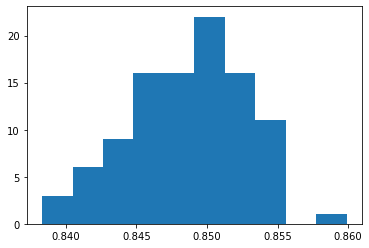

In [69]:
plt.hist(auc_boot)

print(np.mean(auc_boot))

np.quantile(auc_boot, [0.025, 0.975])

In [ ]:
# coefficients in scorecard
def ab(points0=600, odds0=1/19, pdo=50):
    b = pdo/np.log(2)
    a = points0 + b*np.log(odds0) #log(odds0/(1+odds0))
    return {'a':a, 'b':b}

def scorecard(bins, model, xcolumns, points0=600, odds0=1/19, pdo=50, basepoints_eq0=False, digits=0):
    # coefficients
    aabb = ab(points0, odds0, pdo)
    a = aabb['a'] 
    b = aabb['b']
    # odds = pred/(1-pred); score = a - b*log(odds)
    
    # bins # if (is.list(bins)) rbindlist(bins)
    if isinstance(bins, dict):
        bins = pd.concat(bins, ignore_index=True)
    xs = [re.sub('_woe$', '', i) for i in xcolumns]
    # coefficients
    coef_df = pd.Series(model.coef_[0], index=np.array(xs))\
      .loc[lambda x: x != 0]#.reset_index(drop=True)
    
    # scorecard
    len_x = len(coef_df)
    basepoints = a - b*model.intercept_[0]
    card = {}
    if basepoints_eq0:
        card['basepoints'] = pd.DataFrame({'variable':"basepoints", 'bin':np.nan, 'points':0}, index=np.arange(1))
        for i in coef_df.index:
            card[i] = bins.loc[bins['variable']==i,['variable', 'bin', 'woe']]\
              .assign(points = lambda x: round(-b*x['woe']*coef_df[i] + basepoints/len_x), ndigits=digits)\
              [["variable", "bin", "points"]]
    else:
        card['basepoints'] = pd.DataFrame({'variable':"basepoints", 'bin':np.nan, 'points':round(basepoints, ndigits=digits)}, index=np.arange(1))
        for i in coef_df.index:
            card[i] = bins.loc[bins['variable']==i,['variable', 'bin', 'woe']]\
              .assign(points = lambda x: round(-b*x['woe']*coef_df[i]), ndigits=digits)\
              [["variable", "bin", "points"]]
    return card

In [134]:
import importlib
import scorecardpy as sc

model_sc = scorecard(bins_adj, # bins from the WoE
                           model,  # Trained logistic regression
                           X_train_model.columns, # The column names in the trained LR
                           points0=750, # Base points
                           odds0=0.02, # Base odds bads:goods
                           pdo=100 # PDO
                           )

train_score = sc.scorecard_ply(X_train, model_sc,
                               print_step=0)

test_score = sc.scorecard_ply(X_test, model_sc,
                               print_step=0)

oot_score = sc.scorecard_ply(data_full_oot, model_sc,
                               print_step=0)



In [172]:
cutoffs = range(-2000, 1000, 100)
profits = []

oot_with_score = data_full_oot.copy()
oot_with_score['score'] = oot_score['score'].astype(int)

for cut in cutoffs:
    approved = oot_with_score[oot_with_score['score'] >= cut]
    
    good = approved[approved['DEFAULT_NEXT_12'] == 0]
    bad = approved[approved['DEFAULT_NEXT_12'] == 1]
    
    # 收益来自好贷款
    income = 0.3 * good['CURRENT INTEREST RATE']/100 * good['CURRENT ACTUAL UPB']
    
    # 损失来自违约贷款
    loss = 0.4 * bad['CURRENT ACTUAL UPB']
    
    total_profit = income.sum() - loss.sum()
    profits.append(total_profit)

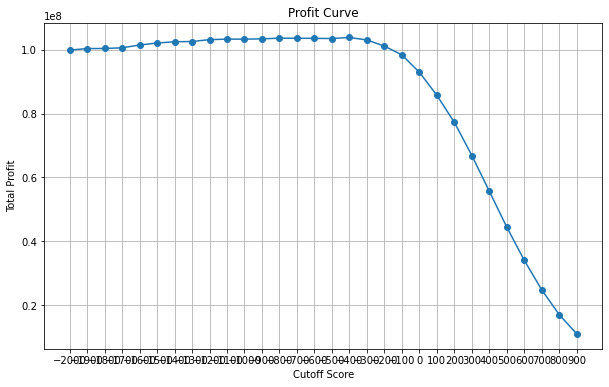

In [173]:
# Plotting the profit curve
plt.figure(figsize=(10, 6))
plt.plot(cutoffs, profits, marker='o')
plt.title('Profit Curve')
plt.xlabel('Cutoff Score')
plt.ylabel('Total Profit')
plt.grid()
plt.xticks(cutoffs)
plt.show()

(array([1.000e+00, 1.000e+00, 4.000e+00, 5.000e+00, 1.100e+01, 2.000e+01,
        1.900e+01, 1.800e+01, 1.500e+01, 2.000e+01, 9.000e+00, 4.000e+00,
        2.000e+00, 0.000e+00, 2.000e+00, 4.000e+00, 6.000e+00, 9.000e+00,
        1.500e+01, 2.400e+01, 1.800e+01, 1.000e+01, 1.800e+01, 1.200e+01,
        2.000e+01, 1.400e+01, 2.600e+01, 2.400e+01, 1.600e+01, 2.500e+01,
        1.700e+01, 1.300e+01, 1.000e+01, 1.700e+01, 4.400e+01, 1.810e+02,
        7.510e+02, 1.636e+03, 2.878e+03, 4.089e+03, 5.125e+03, 5.570e+03,
        5.557e+03, 5.094e+03, 4.225e+03, 2.983e+03, 1.971e+03, 1.113e+03,
        3.580e+02, 4.500e+01]),
 array([-5143.  , -5010.82, -4878.64, -4746.46, -4614.28, -4482.1 ,
        -4349.92, -4217.74, -4085.56, -3953.38, -3821.2 , -3689.02,
        -3556.84, -3424.66, -3292.48, -3160.3 , -3028.12, -2895.94,
        -2763.76, -2631.58, -2499.4 , -2367.22, -2235.04, -2102.86,
        -1970.68, -1838.5 , -1706.32, -1574.14, -1441.96, -1309.78,
        -1177.6 , -1045.42,  -913.24

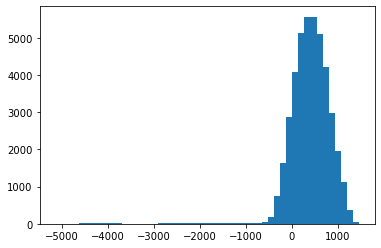

In [168]:
plt.hist(oot_score, bins=50)

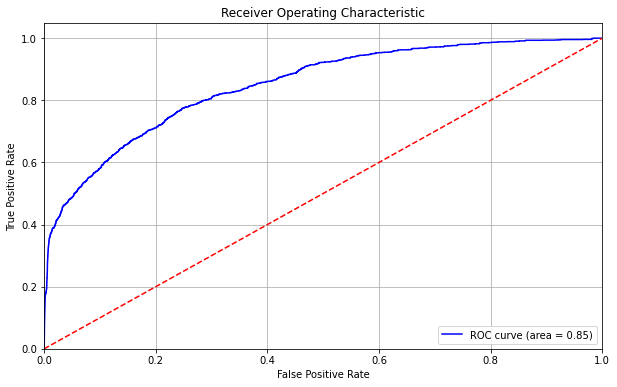

In [174]:
# create auc curve for the logistic regressoin model 

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test_model, y_test_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [ ]:
import pwlf
import numpy as np
import matplotlib.pyplot as plt


# Step 1: 取出预测值和真实违约标签
x = data_full['prob_default'].values
y = data_full['DEFAULT_NEXT_12'].values

# Step 2: 拟合 piecewise linear model（你可以从2-5段中选择，老师用了4段）
model = pwlf.PiecewiseLinFit(x, y)
breaks = model.fit(4)  # 你可以改成 3 或 5 看效果
print("⚡ Segmentation breakpoints based on pwlf:", breaks)

# Step 3: 用 breakpoints 将所有样本分组
def assign_segment(val, breaks):
    for i in range(len(breaks)-1):
        if breaks[i] <= val < breaks[i+1]:
            return f"Segment {i+1}"
    return f"Segment {len(breaks)-1}"  # for the last bin

data_full['SEGMENT'] = data_full['prob_default'].apply(lambda p: assign_segment(p, breaks))

# Step 4: 可视化拟合结果
x_hat = np.linspace(min(x), max(x), 100)
y_hat = model.predict(x_hat)

plt.figure(figsize=(10,6))
plt.plot(x, y, '.', alpha=0.3, label='Data')
plt.plot(x_hat, y_hat, color='red', lw=2, label='Piecewise Linear Fit')
for bp in breaks[1:-1]:  # draw vertical lines at breakpoints
    plt.axvline(bp, color='grey', linestyle='--')
plt.title("Piecewise Linear Fit for PD Segmentation (Q3a)")
plt.xlabel("Predicted PD (Behavioural Model)")
plt.ylabel("Actual Default Indicator")
plt.legend()
plt.grid(True)
plt.show()

KeyError: 'prob_default'

In [ ]:
import pwlf

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

segment_def_rates = data.groupby(['MONTHLY REPORTING PERIOD', 'SEGMENT'])['DEFAULT_NEXT_12'].mean().reset_index()

data_full['SEGMENT'] = pd.qcut(
    data_full['prob_default'],
    q=5,
    labels=['Very Low', 'Low', 'Medium', 'High', 'Very High']
)
